Goal

Online shops often sell tons of different items and this can become very messy very quickly!

Data science can be extremely useful to automatically organize the products in categories so that they can be easily found by the customers.

The goal of this challenge is to look at user purchase history and create categories of items that are likely to be bought together and, therefore, should belong to the same section.

Challenge Description

Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience.

However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use!

This is what they asked you to do:

1.The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:
- the customer who bought the most items overall in her lifetime
- for each item, the customer who bought that product the most

2.Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. 

The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

In [125]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

In [126]:
item_to_id=pd.read_csv('/Users/yangzongkun/Desktop/sd/DS Take Home 6-9/9.grocery cluster/item_to_id.csv')
purchase_history=pd.read_csv('/Users/yangzongkun/Desktop/sd/DS Take Home 6-9/9.grocery cluster/purchase_history.csv')

In [127]:
item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [128]:
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [129]:
print(sorted(item_to_id['Item_id'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [130]:
purchase_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [131]:
purchase_history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


Data Processing


In [132]:
# The function converts a column of comma-separated ids in the DataFrame into a count of occurrences for each id, and returns the counts as a Series object.

def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    # 'df' by commas using the str.split() method, and concatenates all the resulting lists into a single list of ids using the sum() method. The resulting ids variable is a list of strings.
    id_list = [0 for i in range(1, 49)]
    # initializes a list of 48 zeros (one for each possible id in the range 1-48). This list will be used to count the occurrences of each id.
    for i in ids:
        id_list[int(i) - 1] += 1
    # iterates over each id in the ids list, converting it to an integer with int(i), subtracting 1 to make it zero-indexed (since Python lists are zero-indexed), and adding 1 to the corresponding element of the id_list variable.
    return pd.Series(id_list, index=list(range(1, 49)))
    # creates a pandas Series object from the id_list list with an index that ranges from 1 to 48.
    #like this:
    # 1     0
    # 2     0
    # 3     0
    # 4     0
    # 5     0

In [133]:
# get user_item count matrix
user_item_count = purchase_history.groupby('user_id').apply(id_to_item)

user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [134]:
user_item_count.sample(10)

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
25312,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,0,0,0
172815,2,0,0,0,0,1,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
1254282,0,1,0,0,0,1,1,0,0,0,...,1,0,1,0,1,0,0,0,1,0
268303,1,0,0,1,0,0,0,0,0,1,...,0,1,0,1,1,0,0,2,0,0
84068,0,0,0,1,0,1,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
214306,1,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
291040,1,1,0,1,1,1,0,1,1,0,...,1,0,1,0,1,0,1,0,1,2
250714,0,2,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,1
285160,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


Question 1: 


The customer who bought the most items overall in her lifetime

In [135]:
user_item_count.sum(axis=1).sort_values(ascending=False).head()
#the customer who bought the most items is 269335 with 72 items

user_id
269335    72
367872    70
397623    64
599172    64
377284    63
dtype: int64

For each item, the customer who bought that product the most

In [136]:
item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index()
item_user_most.head()

,index,0
0,1,512
1,2,512
2,3,2552
3,4,92
4,5,3605


In [137]:
item_user_most = item_user_most.rename(columns={'index': 'Item_id', 0: 'User_id'})
item_user_most.head()

,Item_id,User_id
0,1,512
1,2,512
2,3,2552
3,4,92
4,5,3605


In [138]:
df = pd.merge(left=item_user_most, right=item_to_id, on='Item_id', how='left')
df[['Item_id', 'Item_name', 'User_id']]

,Item_id,Item_name,User_id
0,1,sugar,512
1,2,lettuce,512
2,3,pet items,2552
3,4,baby items,92
4,5,waffles,3605
5,6,poultry,5555
6,7,sandwich bags,2926
7,8,butter,2493
8,9,soda,4445
9,10,carrots,10238


Question 2: Cluster items based on user co-purchase history.

In [139]:
# define the feature matrix: item_id, user_id
feature = user_item_count.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [140]:
# determine the best number of clusters
clusters = range(2, 30)
inertias = []
silhouettes = []
# The inertias list will be used to plot the elbow curve, which helps to determine the optimal number of clusters 
# and the silhouettes list will be used to assess the quality of clustering.

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=1, n_jobs=-1)
    # using the k-means++ initialization method and n_jobs=-1 to use all available CPU cores
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    # The inertia_ attribute of the KMeans object is the sum of squared distances of samples to their closest cluster center, and this value is appended to the inertias list.
    silhouettes.append(silhouette_score(feature, label))
    # The silhouette_score function from the sklearn.metrics module is used to compute the mean silhouette coefficient of all samples.


    # At the end of the loop, the inertias and silhouettes lists will contain the inertia and silhouette scores for each number of clusters. 
    # These values can be used to determine the optimal number of clusters and to assess the quality of clustering, respectively.

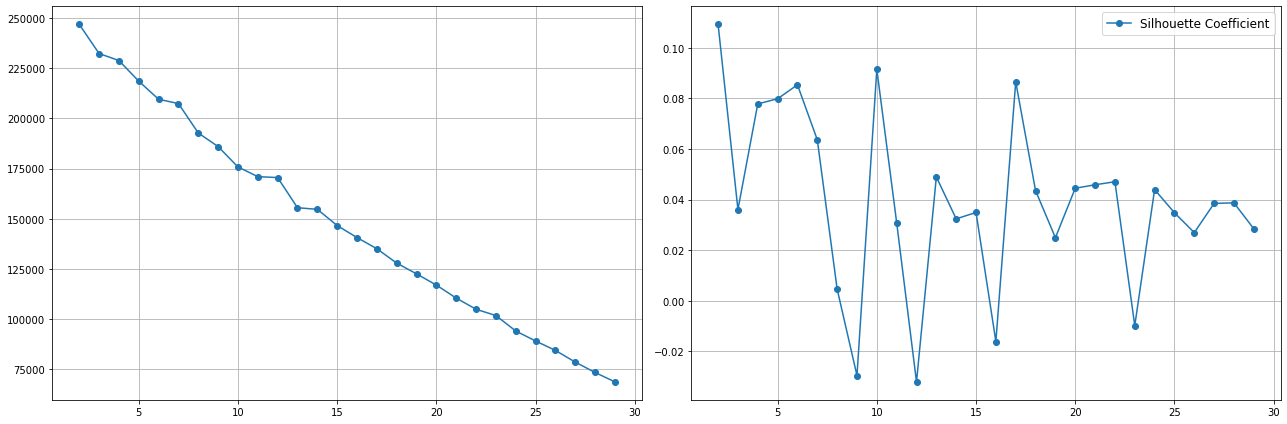

In [141]:
# visualization

# It creates a figure with two subplots: 
# one for the sum of squared distances (inertia) 
# one for the silhouette coefficient.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)

ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
# The 'o-' indicates that a line is drawn connecting the data points in the plot, and the points are represented as circles.

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [142]:
# build K-Means model
kmeans = KMeans(n_clusters=12, init='k-means++', random_state=1, n_jobs=-1)
kmeans = kmeans.fit(feature)

label = kmeans.predict(feature)
# This assigns a label (i.e., cluster number) to each data point 

In [143]:
label

array([ 3,  6,  3,  3,  3, 11,  3,  3,  4,  2,  3,  1,  5,  3,  3,  3, 11,
        3,  1,  0,  3,  3,  4,  3,  8,  3,  3,  3,  1,  3,  3, 10,  3,  5,
        1,  3,  5,  4,  3,  7,  3,  9,  4,  3,  3,  3, 11,  3],
      dtype=int32)

In [144]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=1)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

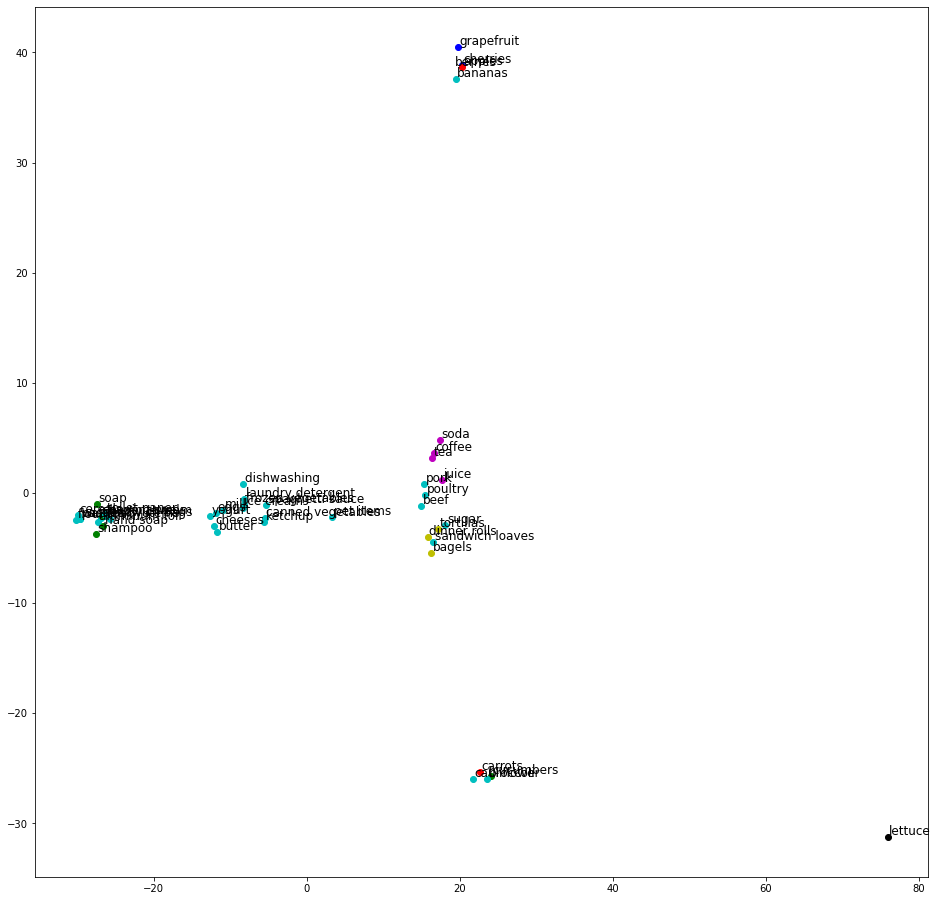

In [145]:
# visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0], fontsize=12)

plt.show()

In [146]:
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df.head()

,Item_id,label
0,1,3
1,2,6
2,3,3
3,4,3
4,5,3


In [147]:
df.shape

(48, 2)

In [148]:
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')
df.head()

,Item_id,label,Item_name
0,1,3,sugar
1,2,6,lettuce
2,3,3,pet items
3,4,3,baby items
4,5,3,waffles


In [149]:
# print useful information
for i in range(0, 12):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['grapefruit']
1 	 ['shampoo', 'shaving cream', 'hand soap', 'soap']
2 	 ['carrots']
3 	 ['sugar', 'pet items', 'baby items', 'waffles', 'sandwich bags', 'butter', 'cereals', 'eggs', 'aluminum foil', 'milk', 'laundry detergent', 'cheeses', 'frozen vegetables', 'paper towels', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'flour', 'pasta', 'toilet paper', 'ice cream', 'sandwich loaves', 'ketchup', 'broccoli', 'cauliflower', 'bananas', 'yogurt']
4 	 ['soda', 'tea', 'juice', 'coffee']
5 	 ['bagels', 'tortillas', 'dinner rolls']
6 	 ['lettuce']
7 	 ['berries']
8 	 ['cherries']
9 	 ['cucumbers']
10 	 ['apples']
11 	 ['poultry', 'beef', 'pork']
